# Lets Play!

Connect X or Connect 4 is a popular game where each player takes turns placing down their tokens.The other player can block its opponent in order to stop them to get four in a row. The players can get four in a row by doing vertically, horizontally,or diagonally. The first player to get four in a row wins.

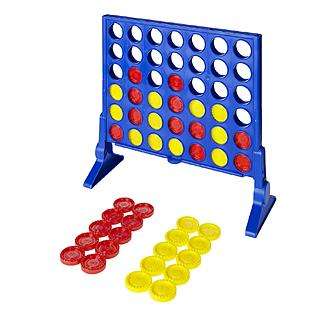

# Install kaggle-environments

In [ ]:
# 1. Enable Internet in the Kernel (Settings side pane)
import sys
import inspect
import os
# 2. Curl cache may need purged if v0.1.6 cannot be found (uncomment if needed). 
# !curl -X PURGE https://pypi.org/simple/kaggle-environments

# ConnectX environment was defined in v0.1.6
!pip install 'kaggle-environments>=0.1.6'

# Create ConnectX Environment

In [ ]:
from kaggle_environments import evaluate, make, utils

env = make("connectx", debug=True)
env.render()

# Create an Agent

To create the submission, an agent function should be fully encapsulated (no external dependencies).  

When your agent is being evaluated against others, it will not have access to the Kaggle docker image.  Only the following can be imported: Python Standard Library Modules, gym, numpy, scipy, pytorch (1.3.1, cpu only), and more may be added later.



In [ ]:
def my_agent(obs, conf):
    def get_results(x, y, mark, multiplier):
        """ get list of points, lowest cells and "in air" cells of a board[x][y] cell considering mark """
        # set board[x][y] as mark
        board[x][y] = mark
        results = []
        # if some points in axis already found - axis blocked
        blocked = [False, False, False, False]
        # i is amount of marks required to add points
        for i in range(conf.inarow, 2, -1):
            # points
            p = 0
            # lowest cell
            lc = 0
            # "in air" points
            ap = 0
            # axis S -> N, only if one mark required for victory
            if i == conf.inarow and blocked[0] is False:
                (p, lc, ap, blocked[0]) = process_results(p, lc, ap,
                              check_axis(mark, i, x, lambda z : z, y + inarow_m1, lambda z : z - 1))
            # axis SW -> NE
            if blocked[1] is False:
                (p, lc, ap, blocked[1]) = process_results(p, lc, ap,
                    check_axis(mark, i, x - inarow_m1, lambda z : z + 1, y + inarow_m1, lambda z : z - 1))
            # axis E -> W
            if blocked[2] is False:
                (p, lc, ap, blocked[2]) = process_results(p, lc, ap,
                    check_axis(mark, i, x + inarow_m1, lambda z : z - 1, y, lambda z : z))
            # axis SE -> NW
            if blocked[3] is False:
                (p, lc, ap, blocked[3]) = process_results(p, lc, ap, 
                    check_axis(mark, i, x + inarow_m1, lambda z : z - 1, y + inarow_m1, lambda z : z - 1))
            results.append((p * multiplier, lc, ap))
        # restore board[x][y] original value
        board[x][y] = 0
        return results
    
    def check_axis(mark, inarow, x, x_fun, y, y_fun):
        """ check axis (NE -> SW etc.) for lowest cell and amounts of points and "in air" cells """
        (x, y, axis_max_range) = get_x_y_and_axis_max_range(x, x_fun, y, y_fun)
        zeros_allowed = conf.inarow - inarow
        #lowest_cell = y
        # lowest_cell calculation turned off
        lowest_cell = 0
        for i in range(axis_max_range):
            x_temp = x
            y_temp = y
            zeros_remained = zeros_allowed
            marks = 0
            # amount of empty cells that are "in air" (don't have board bottom or mark under them)
            in_air = 0
            for j in range(conf.inarow):
                if board[x_temp][y_temp] != mark and board[x_temp][y_temp] != 0:
                    break
                elif board[x_temp][y_temp] == mark:
                    marks += 1
                # board[x_temp][y_temp] is 0
                else:
                    zeros_remained -= 1
                    if (y_temp + 1) < conf.rows and board[x_temp][y_temp + 1] == 0:
                        in_air -= 1
#                 if y_temp > lowest_cell:
#                     lowest_cell = y_temp
                if marks == inarow and zeros_remained == 0:
                    return (sp, lowest_cell, in_air, True)
                x_temp = x_fun(x_temp)
                y_temp = y_fun(y_temp)
                if y_temp < 0 or y_temp >= conf.rows or x_temp < 0 or x_temp >= conf.columns:
                    return (0, 0, 0, False)
            x = x_fun(x)
            y = y_fun(y)
        return (0, 0, 0, False)
        
    def get_x_y_and_axis_max_range(x, x_fun, y, y_fun):
        """ set x and y inside board boundaries and get max range of axis """
        axis_max_range = conf.inarow
        while y < 0 or y >= conf.rows or x < 0 or x >= conf.columns:
            x = x_fun(x)
            y = y_fun(y)
            axis_max_range -= 1
        return (x, y, axis_max_range)
    
    def process_results(p, lc, ap, axis_check_results):
        """ process results of check_axis function, return lowest cell and sums of points and "in air" cells """
        (points, lowest_cell, in_air, blocked) = axis_check_results
        if points > 0:
            if lc < lowest_cell:
                lc = lowest_cell
            ap += in_air
            p += points
        return (p, lc, ap, blocked)
    
    def get_best_cell(best_cell, current_cell):
        """ get best cell by comparing factors of cells """
        for i in range(len(current_cell["factors"])):
            # index 0 = points, 1 = lowest cell, 2 = "in air" cells
            for j in range(3):
                # if value of best cell factor is smaller than value of
                # the same factor in the current cell
                # best cell = current cell and break the loop,
                # don't compare lower priority factors
                if best_cell["factors"][i][j] < current_cell["factors"][i][j]:
                    return current_cell
                # if value of best cell factor is bigger than value of
                # the same factor in the current cell
                # break loop and don't compare lower priority factors
                if best_cell["factors"][i][j] > current_cell["factors"][i][j]:
                    return best_cell
        return best_cell
    
    def get_factors(results):
        """ get list of factors represented by results and ordered by priority from highest to lowest """
        factors = []
        for i in range(conf.inarow - 2):
            if i == 1:
                # my checker in this cell means my victory two times
                factors.append(results[0][0][i] if results[0][0][i][0] > st else (0, 0, 0))
                # opponent's checker in this cell means my defeat two times
                factors.append(results[0][1][i] if results[0][1][i][0] > st else (0, 0, 0))
                # if there are results of a cell one row above current
                if len(results) > 1:
                    # opponent's checker in cell one row above current means my defeat two times
                    factors.append(results[1][1][i] if -results[1][1][i][0] > st else (0, 0, 0))
                    # my checker in cell one row above current means my victory two times
                    factors.append(results[1][0][i] if -results[1][0][i][0] > st else (0, 0, 0))
                else:
                    for j in range(2):
                        factors.append((0, 0, 0))
            else:
                for j in range(2):
                    factors.append((0, 0, 0))
                for j in range(2):
                    factors.append((0, 0, 0))
            # consider only if there is no "in air" cells
            if results[0][1][i][2] == 0:
                # placing opponent's checker in this cell means opponent's victory
                factors.append(results[0][1][i])
            else:
                factors.append((0, 0, 0))
            # placing my checker in this cell means my victory
            factors.append(results[0][0][i])
            # central column priority
            factors.append((1 if i == 1 and shift == 0 else 0, 0, 0))
            # if there are results of a cell one row above current
            if len(results) > 1:
                # opponent's checker in cell one row above current means my defeat
                factors.append(results[1][1][i])
                # my checker in cell one row above current means my victory
                factors.append(results[1][0][i])
            else:
                for j in range(2):
                    factors.append((0, 0, 0))
        # if there are results of a cell two rows above current
        if len(results) > 2:
            for i in range(conf.inarow - 2):
                # my checker in cell two rows above current means my victory
                factors.append(results[2][0][i])
                # opponent's checker in cell two rows above current means my defeat
                factors.append(results[2][1][i])
        else:
            for i in range(conf.inarow - 2):
                for j in range(2):
                    factors.append((0, 0, 0))
        return factors


    # define my mark and opponent's mark
    my_mark = obs.mark
    opp_mark = 2 if my_mark == 1 else 1
    
    # define board as two dimensional array
    board = []
    for column in range(conf.columns):
        board.append([])
        for row in range(conf.rows):
            board[column].append(obs.board[conf.columns * row + column])
    
    best_cell = None
    board_center = conf.columns // 2
    inarow_m1 = conf.inarow - 1
    
    # standard amount of points
    sp = 1
    # "seven" pattern threshold points
    st = 1
    
    # start searching for best_cell from board center
    x = board_center
    
    # shift to right or left from board center
    shift = 0
    
    # searching for best_cell
    while x >= 0 and x < conf.columns:
        # find first empty cell starting from bottom of the column
        y = conf.rows - 1
        while y >= 0 and board[x][y] != 0:
            y -= 1
        # if column is not full
        if y >= 0:
            # results of current cell and cells above it
            results = []
            results.append((get_results(x, y, my_mark, 1), get_results(x, y, opp_mark, 1)))
            # if possible, get results of a cell one row above current
            if (y - 1) >= 0:
                results.append((get_results(x, y - 1, my_mark, -1), get_results(x, y - 1, opp_mark, -1)))
            # if possible, get results of a cell two rows above current
            if (y - 2) >= 0:
                results.append((get_results(x, y - 2, my_mark, 1), get_results(x, y - 2, opp_mark, 1)))
            
            # list of factors represented by results
            # ordered by priority from highest to lowest
            factors = get_factors(results)

            # if best_cell is not yet found
            if best_cell is None:
                best_cell = {
                    "column": x,
                    "factors": factors
                }
            # compare values of factors in best cell and current cell
            else:
                current_cell = {
                    "column": x,
                    "factors": factors
                }
                best_cell = get_best_cell(best_cell, current_cell)
                        
        # shift x to right or left from board center
        if shift >= 0: shift += 1
        shift *= -1
        x = board_center + shift

    # return index of the best cell column
    return best_cell["column"]

# Test your Agent

**The numbers just change the size of the screen**

In [ ]:
env.reset()
# Play as the first agent against default "random" agent.
env.run([my_agent, "random"])
env.render(mode="ipython", width=450, height=450)

# Debug/Train your Agent

In [ ]:
# Play as first position against negamax agent.
trainer = env.train([None, "negamax"])

observation = trainer.reset()

while not env.done:
    my_action = my_agent(observation, env.configuration)
    print("My Action", my_action)
    observation, reward, done, info = trainer.step(my_action)
    # env.render(mode="ipython", width=100, height=90, header=False, controls=False)
env.render()

# Evaluate your Agent

In [ ]:
def mean_reward(rewards):
    return "won {0} of {1}".format(sum(r[0] for r in rewards), len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))

# Play your Agent
Click on any column to place a checker there ("manually select action").

In [ ]:
# "None" represents which agent you'll manually play as (first or second player).
#env.play([my_agent, None], width=500, height=450)
env.play([None, my_agent], width=500, height=450)

# Write Submission File



In [ ]:
def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(my_agent, "submission.py")

# Validate Submission
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents.

Why validate? This roughly verifies that your submission is fully encapsulated and can be run remotely.

In [ ]:
out = sys.stdout
submission = utils.read_file("/kaggle/working/submission.py")
agent = utils.get_last_callable(submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

# If you like this notebook, please give an Upvote! Don't forget to check out my other notebooks too!

* [ConnectX Baseline](https://www.kaggle.com/brendan45774/connectx-baseline)
* [Countries Life Expectancy Animation](https://www.kaggle.com/brendan45774/countries-life-expectancy-animation)
* [Data Visuals - Matplotlib](http://www.kaggle.com/brendan45774/data-visuals-matplotlib)
* [Digit Recognizer Solution](http://www.kaggle.com/brendan45774/digit-recognizer-solution)
* [Dictionary and Pandas Cheat sheet](https://www.kaggle.com/brendan45774/dictionary-and-pandas-cheat-sheet)
* [EDA Tutorial Hollywood Movies](https://www.kaggle.com/brendan45774/eda-tutorial-hollywood-movies)
* [Getting Started with Manifold Learning - Isomap](https://www.kaggle.com/brendan45774/getting-started-with-manifold-learning-isomap)
* [Getting started with Matplotlib](http://www.kaggle.com/brendan45774/getting-started-with-matplotlib)
* [Guide to Matplotlib Image](https://www.kaggle.com/brendan45774/guide-to-matplotlib-image)
* [HOG features - Histogram of Oriented Gradients](https://www.kaggle.com/brendan45774/hog-features-histogram-of-oriented-gradients)
* [How to get the lowest score](https://www.kaggle.com/brendan45774/how-to-get-the-lowest-score)
* [House predict solution](http://www.kaggle.com/brendan45774/house-predict-solution)
* [K-Means Clustering (Image Compression)](https://www.kaggle.com/brendan45774/k-means-clustering-image-compression)
* [Kuzushiji-MNIST Panda](http://www.kaggle.com/brendan45774/kuzushiji-mnist-panda)
* [Plotly Coronavirus (Covid-19)](https://www.kaggle.com/brendan45774/plotly-coronavirus-covid-19)
* [Titanic Top Solution](http://www.kaggle.com/brendan45774/titanic-top-solution)
* [Titanic Data Solution](http://www.kaggle.com/brendan45774/titanic-data-solution)
* [Topic Modeling (LDA)](https://www.kaggle.com/brendan45774/topic-modeling-lda)
* [Word Cloud - Analyzing Names](https://www.kaggle.com/brendan45774/word-cloud-analyzing-names)